In [1]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
from tqdm import tqdm

In [2]:
class Particle:
    
    def __init__(self, r0, v0, a0, t, m=1, radius=2., Id=0):
        
        self.dt = t[1] - t[0]
        
        
        # Atributos instantaneos
        self.r = r0
        self.v = v0
        self.a = a0
        
        self.m = m
        self.radius = radius
        self.Id = Id
        
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        self.f = self.m*self.a
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        
        # Historial
        
        self.R = np.zeros((len(t),len(r0)))
        self.V = np.zeros_like(self.R)
        self.A = np.zeros_like(self.R)
        
        self.F = np.zeros_like(self.R)
        
        self.P = np.zeros_like(self.R)
    
        # Fisica
        self.K = 20.
        
        self.Ek = np.zeros(len(t))
        self.Eu = np.zeros_like(self.Ek)
        self.L = np.zeros_like(self.Ek)
        
    def Evolution(self,i):
        
        
        self.SetPosition(i)
        self.SetVelocity(i)
        self.SetMomentum(i)
        self.SetAngularMomentum(i)
        self.SetKineticEnergy(i)
        
        self.a = self.f/self.m

        
        # Euler
        self.r += self.dt*self.v
        self.v += self.dt*self.a
        
        # Euler-Cromer
        #self.v += self.dt*self.a
        #self.r += self.dt*self.v
        
        self.p = self.m*self.v
        self.l = np.cross(self.r,self.p)
        self.ek = 0.5*self.m*np.dot(self.v,self.v)
        
    def CalculateForce(self,p,it):
        
        d = np.linalg.norm(self.r - p.r)
        
        compresion = self.radius + p.radius - d
        
        if compresion >= 0:
            
            Fn = self.K * compresion**3
            
            self.n = (self.r - p.r)/d     
            self.f = np.add(self.f,Fn*self.n)
            
            # Falta implementar energía potencial 
            
            #self.Eu[it] = np.add(self.Eu[it], 0.25*self.K*compresion**4) #Revisar, porque Fn no es estándar. ie Fn != kx
            
     
    # Aca debes agregar la energía potencial
    def ResetForce(self):
        self.f[:] = 0.
        self.a[:] = 0.
    
    # Setter
    def SetPosition(self,i):
        self.R[i] = self.r
    
    def SetVelocity(self,i):
        self.V[i] = self.v
        
    def SetMomentum(self,i):
        self.P[i] = self.p
        
    def SetAngularMomentum(self,i):
        self.L[i] = self.l
        
    def SetKineticEnergy(self,i):
        self.Ek[i] = self.ek
    
    # Getter
    def GetPosition(self,scale=1):
        return self.R[::scale]
    
    def GetVelocity(self,scale=1):
        return self.V[::scale]
 
    def GetMomentum(self,scale=1):
        return self.P[::scale]
    
    def GetAngularMomentum(self,scale=1):
        return self.L[::scale]
    
    def GetKineticEnergy(self,scale=1):
        return self.Ek[::scale]
    
    def GetPotentialEnergy(self,scale=1):
        return self.Eu[::scale]
    
    # Debes agregar las paredes en este punto
    
    def CheckLimits(self):
        
        Limits = np.array([[-20.,20.],[-20.,20.]])
        
        for i in range(2):
        
            if self.r[i] + self.radius > Limits[i][1] and self.v[i] > 0.:
                self.v[i] = -1.0*self.v[i]
            if self.r[i] - self.radius < Limits[i][0] and self.v[i] < 0.:
                self.v[i] = -1.0*self.v[i]

In [3]:
def GetParticles(N,t):

    Particles = [0]*N

    for i in range(N):
        r0 = np.array([np.random.uniform(-20,20),np.random.uniform(-20,20)])
        v0 = np.array([np.random.uniform(-5,5),np.random.uniform(-5,5)])
        a0 = np.array([0.,0.])
        p = Particle(r0,v0,a0,t,m=1,radius=2,Id=i)
        Particles[i] = p
    
    # Aca deber agregar una rutina montecarlo para crear particulas
    # sobre el plano con velocidades aleatorias.
    
    return Particles

In [5]:
dt = 0.001
tmax = 10
t = np.arange(0,tmax,dt)
Particles = GetParticles(10,t)

In [6]:
def RunSimulation(t,Particles):
    
    for it in tqdm(range(len(t)), desc='Running simulation', unit=' Steps' ):
        
        for i in range(len(Particles)):
            for j in range(len(Particles)):
                if i!=j:
                    Particles[i].CalculateForce(Particles[j], it)
        
        for i in range(len(Particles)):
            Particles[i].Evolution(it)
            Particles[i].ResetForce()
            
            # Aca debes agregar la interaccion con la pared
            
            #Particles[i].CheckLimits()
            
            
    return Particles

In [7]:
Particles = RunSimulation(t,Particles)

Running simulation: 100%|██████████| 10000/10000 [00:05<00:00, 1763.66 Steps/s]


In [8]:
# Bajamos dimensión de la simulacion
scale = 200
t1 = t[::scale]

<IPython.core.display.Javascript object>


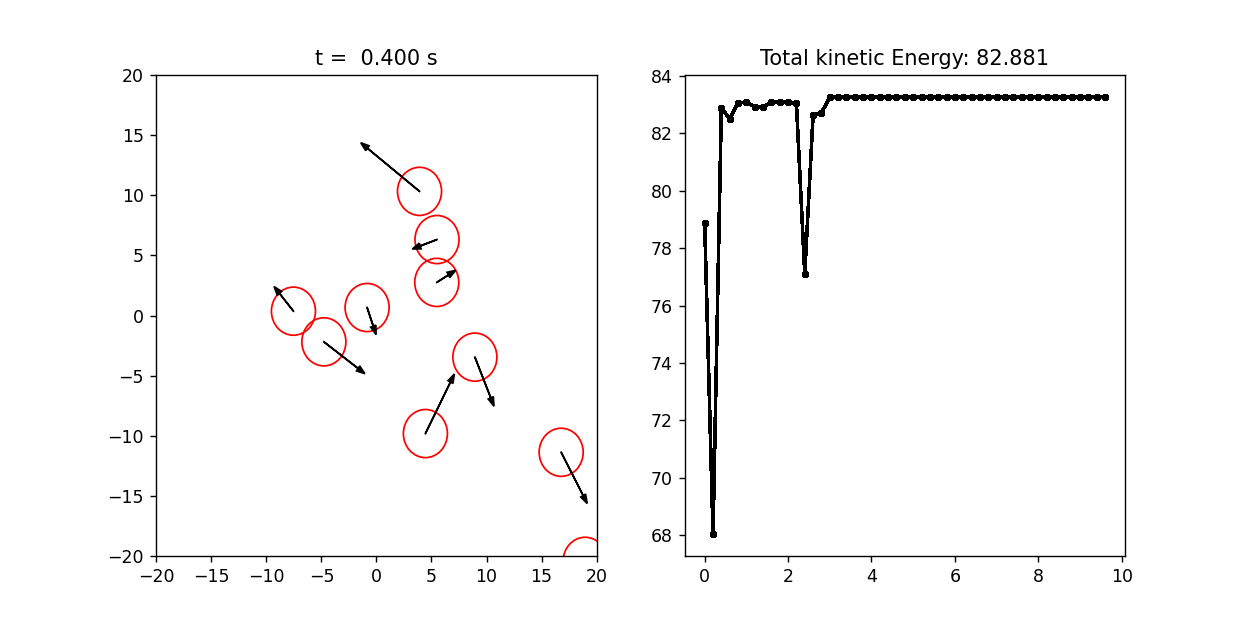

In [19]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
KEtotal = np.zeros(len(t1))

def init():
    
    ax.clear()
    ax.set_xlim(-20,20)
    ax.set_ylim(-20,20)
    
def Update(i):
    
    init()
    ax.set_title(r't =  %.3f s' %(t1[i]))
    
    
    # Queremos calcular la energía total de cinética
    KEcurrent = 0. # Kinetic energy
    
    for p in Particles:
        
        x = p.GetPosition(scale)[i,0]
        y = p.GetPosition(scale)[i,1]
        
        vx = p.GetVelocity(scale)[i,0]
        vy = p.GetVelocity(scale)[i,1]
        
        circle = plt.Circle( (x,y), p.radius, color='r', fill=False )
        ax.add_patch(circle)
        
        ax.arrow(x,y,vx,vy,color='k',head_width=0.5,length_includes_head=True)
        
        KEcurrent += p.GetKineticEnergy(scale)[i]
        
    KEtotal[i] = KEcurrent
        
    ax1.set_title(r'Total kinetic Energy: {:.3f}'.format(KEcurrent))
    ax1.plot(t1[:i], KEtotal[:i],color='k',marker='.')
        
Animation = anim.FuncAnimation(fig,Update,frames=len(t1),init_func=init)

In [11]:
MomentumT = Particles[0].GetMomentum(scale)

In [12]:
for i in range(1,len(Particles)):
    MomentumT = np.add(MomentumT,Particles[i].GetMomentum(scale))

In [13]:
AngularMomentumT = Particles[0].GetAngularMomentum(scale)

In [14]:
for i in range(1,len(Particles)):
    AngularMomentumT = np.add(AngularMomentumT,Particles[i].GetAngularMomentum(scale))

<IPython.core.display.Javascript object>


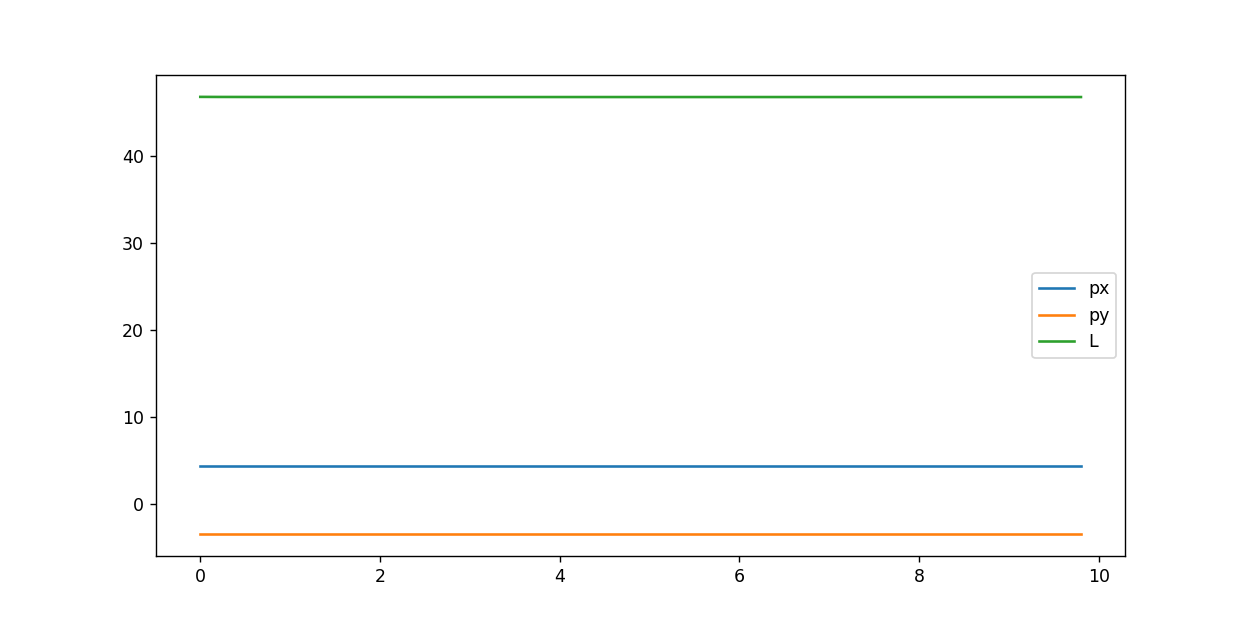

In [16]:
fig3 = plt.figure(figsize=(10,5))
ax3 = fig3.add_subplot(111)
ax3.plot(t1,MomentumT[:,0],label='px')
ax3.plot(t1,MomentumT[:,1],label='py')
ax3.plot(t1, AngularMomentumT,label='L')
ax3.legend()